<a href="https://colab.research.google.com/github/Vikhyat-1820/Image-Sementic-Segmentation/blob/master/Image_Sementic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import imageio
from keras.models import Model,load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras import backend as K

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
image_list=os.listdir('/content/drive/My Drive/dataA/CameraRGB')
mask_list=os.listdir('/content/drive/My Drive/dataA/CameraSeg')

In [0]:
image_path='/content/drive/My Drive/dataA/CameraRGB/'
mask_path='/content/drive/My Drive/dataA/CameraSeg/'

In [0]:
image_list=[image_path+i for i in image_list]
mask_list=[mask_path+i for i in mask_list]

In [0]:
image_list[0]

'/content/drive/My Drive/dataA/CameraRGB/02_00_070.png'

In [0]:
height=600
width=800
images=np.zeros((len(image_list),height,width,3),dtype=np.int16)
masks=np.zeros((len(mask_list),height,width,1),dtype=np.int8)

In [0]:
for i in tqdm(range(len(image_list))):
  img=imageio.imread(image_list[i])
  mask=imageio.imread(mask_list[i])
  mask_road=np.zeros((height,width,1),dtype=np.int8)
  mask_road[np.where(mask==10)[0],np.where(mask==10)[1]]=1
  images[i]=img
  masks[i]=mask_road

100%|██████████| 1000/1000 [17:19<00:00,  1.04s/it]


In [0]:
s_id=np.array([i for i in range(len(images))])

In [0]:
np.random.shuffle(s_id)

In [0]:
train_id=s_id[0:800]
val_id=s_id[800:900]
test_id=s_id[900:]

In [0]:
train_img,train_mask=images[train_id],masks[train_id]
val_img,val_mask=images[val_id],masks[val_id]
test_img,test_mask=images[test_id],masks[test_id]

In [0]:
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 600, 800, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
results = model.fit(train_img, train_mask, batch_size=16, epochs=5,
                    validation_data=(val_img, val_mask))

Train on 800 samples, validate on 100 samples
Epoch 1/5
800/800 [==============================] - 1863s 2s/step - loss: 0.1462 - val_loss: 0.1190
Epoch 2/5
800/800 [==============================] - 1930s 2s/step - loss: 0.1069 - val_loss: 0.1094
Epoch 3/5
800/800 [==============================] - 1928s 2s/step - loss: 0.0990 - val_loss: 0.0967
Epoch 4/5
800/800 [==============================] - 1915s 2s/step - loss: 0.0851 - val_loss: 0.0820
Epoch 5/5
800/800 [==============================] - 1933s 2s/step - loss: 0.0799 - val_loss: 0.0769


In [0]:
model.save('Sementic_segmentation.h5')

In [0]:
my_preds = model.predict(np.expand_dims(test_img[0], 0))

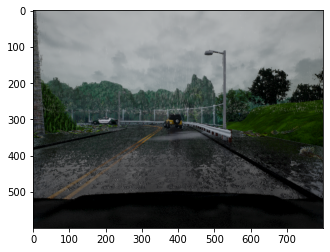

In [0]:
plt.imshow(test_img[0])

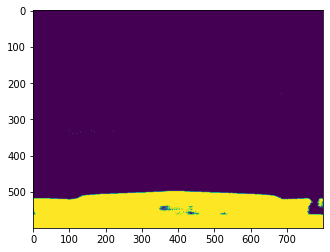

In [0]:
my_preds=my_preds.flatten()
my_preds = np.array([1 if i >= 0.5 else 0 for i in my_preds])
plt.imshow(my_preds.reshape(600,800))

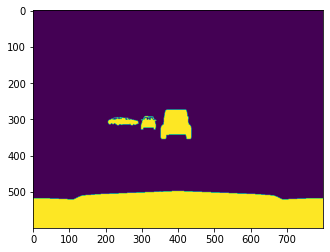

In [0]:
plt.imshow(test_mask[0].reshape(600,800))

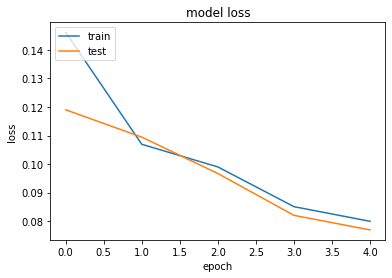

In [0]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()